In [63]:
import os  
import sys
sys.path.append("../")
from sunerf.model.mhd_model import MHDModel
import torch  
from sunerf.model.sunerf import DensityTemperatureSuNeRFModule
from sunerf.data.fibonacci_sphere import fibonacci_sphere
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [11]:
# path to MHD datasets
data_path = '/mnt/disks/data/MHD'

# define baseline un-trained MHD model
mhd_model = MHDModel(data_path=data_path)
# print(output_density, output_temperature)


In [14]:
# path to last checkpoint
checkpoint_path = "/mnt/disks/data/sunerfs/psi/mhd_512_checkpoint_8-13/checkpoints/last.ckpt"

# load SuNeRF model
sunerf_model = DensityTemperatureSuNeRFModule.load_from_checkpoint(checkpoint_path)
print(sunerf_model)

TypeError: DensityTemperatureSuNeRFModule.__init__() missing 4 required positional arguments: 'Rs_per_ds', 'seconds_per_dt', 'image_scaling_config', and 'model'

In [16]:
# path to last checkpoint
checkpoint_path = "/mnt/disks/data/sunerfs/psi/mhd_512_checkpoint_8-13/checkpoints/save_state.snf"

# load SuNeRF model
sunerf_model = torch.load(checkpoint_path)

print(sunerf_model)

{'rendering': DensityTemperatureRadiativeTransfer(
  (sampler): StratifiedSampler()
  (sampler_hierarchical): HierarchicalSampler()
  (coarse_model): NeRF_DT(
    (act): Sine()
    (in_layer): Sequential(
      (0): PositionalEncoding()
      (1): Linear(in_features=84, out_features=512, bias=True)
    )
    (layers): ModuleList(
      (0-6): 7 x Linear(in_features=512, out_features=512, bias=True)
    )
    (out_layer): Linear(in_features=512, out_features=2, bias=True)
    (log_absortpion): ParameterDict(
        (94): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
        (131): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
        (171): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
        (193): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
        (211): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
        (304): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
        

In [41]:
n_layers = 6 # how many concentric shells  
delta_r = .3 # disntance b/w shells in solar radii 

# define coordinates of the sphere
coordinates = []
for i in range(n_layers):
    coordinates.append(np.array(fibonacci_sphere(np.random.randint(1200, 4200)))*(1 + i*delta_r/(n_layers-1)))

# write coords to array    
coordinates = np.concatenate(coordinates)
x = coordinates[:,0]
y = coordinates[:,1]
z = coordinates[:,2]

# radius
r = np.sqrt(x**2 + y**2 + z**2)
 
# only keeping the coords for which radius>1 
x = x[r>1]
y = y[r>1]
z = z[r>1]
r = r[r>1]

# concatinate coordinates to query form ([x, y, z, t])
t = z[:,None]*0 # create query time placeholder
coordinates = np.concatenate((x[:,None], y[:,None], z[:,None], t), axis=1)
# coordinates.shape >> (12286, 4)

# convert coordinates to torch tensor and convert to float objs
coordinates = torch.tensor(coordinates).cuda().to(torch.float32)


In [33]:
sunerf_model.keys()

dict_keys(['rendering', 'data_config', 'Rs_per_ds', 'seconds_per_dt', 'ref_time'])

In [49]:
# load queries into sunerf model
sunerf_output = sunerf_model["rendering"].fine_model.forward(coordinates)

# get temperature, density for sunerf
t_nerf = sunerf_output['inferences'][:,1].detach().cpu().numpy()
rho_nerf = sunerf_output['inferences'][:,0].detach().cpu().numpy()

# check
sunerf_output

{'inferences': tensor([[ 9.9968,  5.0892],
         [10.9205,  4.9066],
         [11.8657,  4.8057],
         ...,
         [10.4590,  5.1234],
         [10.8217,  5.0134],
         [10.5765,  5.2196]], device='cuda:0', grad_fn=<CopySlices>),
 'log_abs': ParameterDict(
     (94): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
     (131): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
     (171): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
     (193): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
     (211): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
     (304): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
     (335): Parameter containing: [torch.cuda.FloatTensor of size  (cuda:0)]
 ),
 'vol_c': Parameter containing:
 tensor(1.1434, device='cuda:0', requires_grad=True)}

In [50]:
# load queries into mhd model
mhd_output = mhd_model.forward(coordinates)

# get temperature, density for mhd model
t_mhd = mhd_output['inferences'][:,1].detach().cpu().numpy()
rho_mhd = mhd_output['inferences'][:,0].detach().cpu().numpy()

# check
mhd_output 


{'inferences': tensor([[10.5967,  2.8000],
         [10.5966,  2.7598],
         [10.5967,  2.8063],
         ...,
         [-0.8538,  4.7909],
         [-0.5290,  4.7910],
         [-0.7894,  4.7983]], device='cuda:0'),
 'log_abs': ParameterDict(
     (94): Parameter containing: [torch.FloatTensor of size ]
     (131): Parameter containing: [torch.FloatTensor of size ]
     (171): Parameter containing: [torch.FloatTensor of size ]
     (193): Parameter containing: [torch.FloatTensor of size ]
     (211): Parameter containing: [torch.FloatTensor of size ]
     (304): Parameter containing: [torch.FloatTensor of size ]
     (335): Parameter containing: [torch.FloatTensor of size ]
 ),
 'vol_c': Parameter containing:
 tensor(1., requires_grad=True)}

In [59]:
def perfect_axis(ax, x, y):
    ''' create square plots with equal x/y axes'''

    plot_dim = max([max(x), max(y), abs(min(x)), abs(min(y))])
    print(f"dimension: {plot_dim}")
    ax.set_xlim([-plot_dim, plot_dim])
    ax.set_ylim([-plot_dim, plot_dim])
    ax.set_aspect("equal")
    

Text(0.5, 1.0, 'Density')

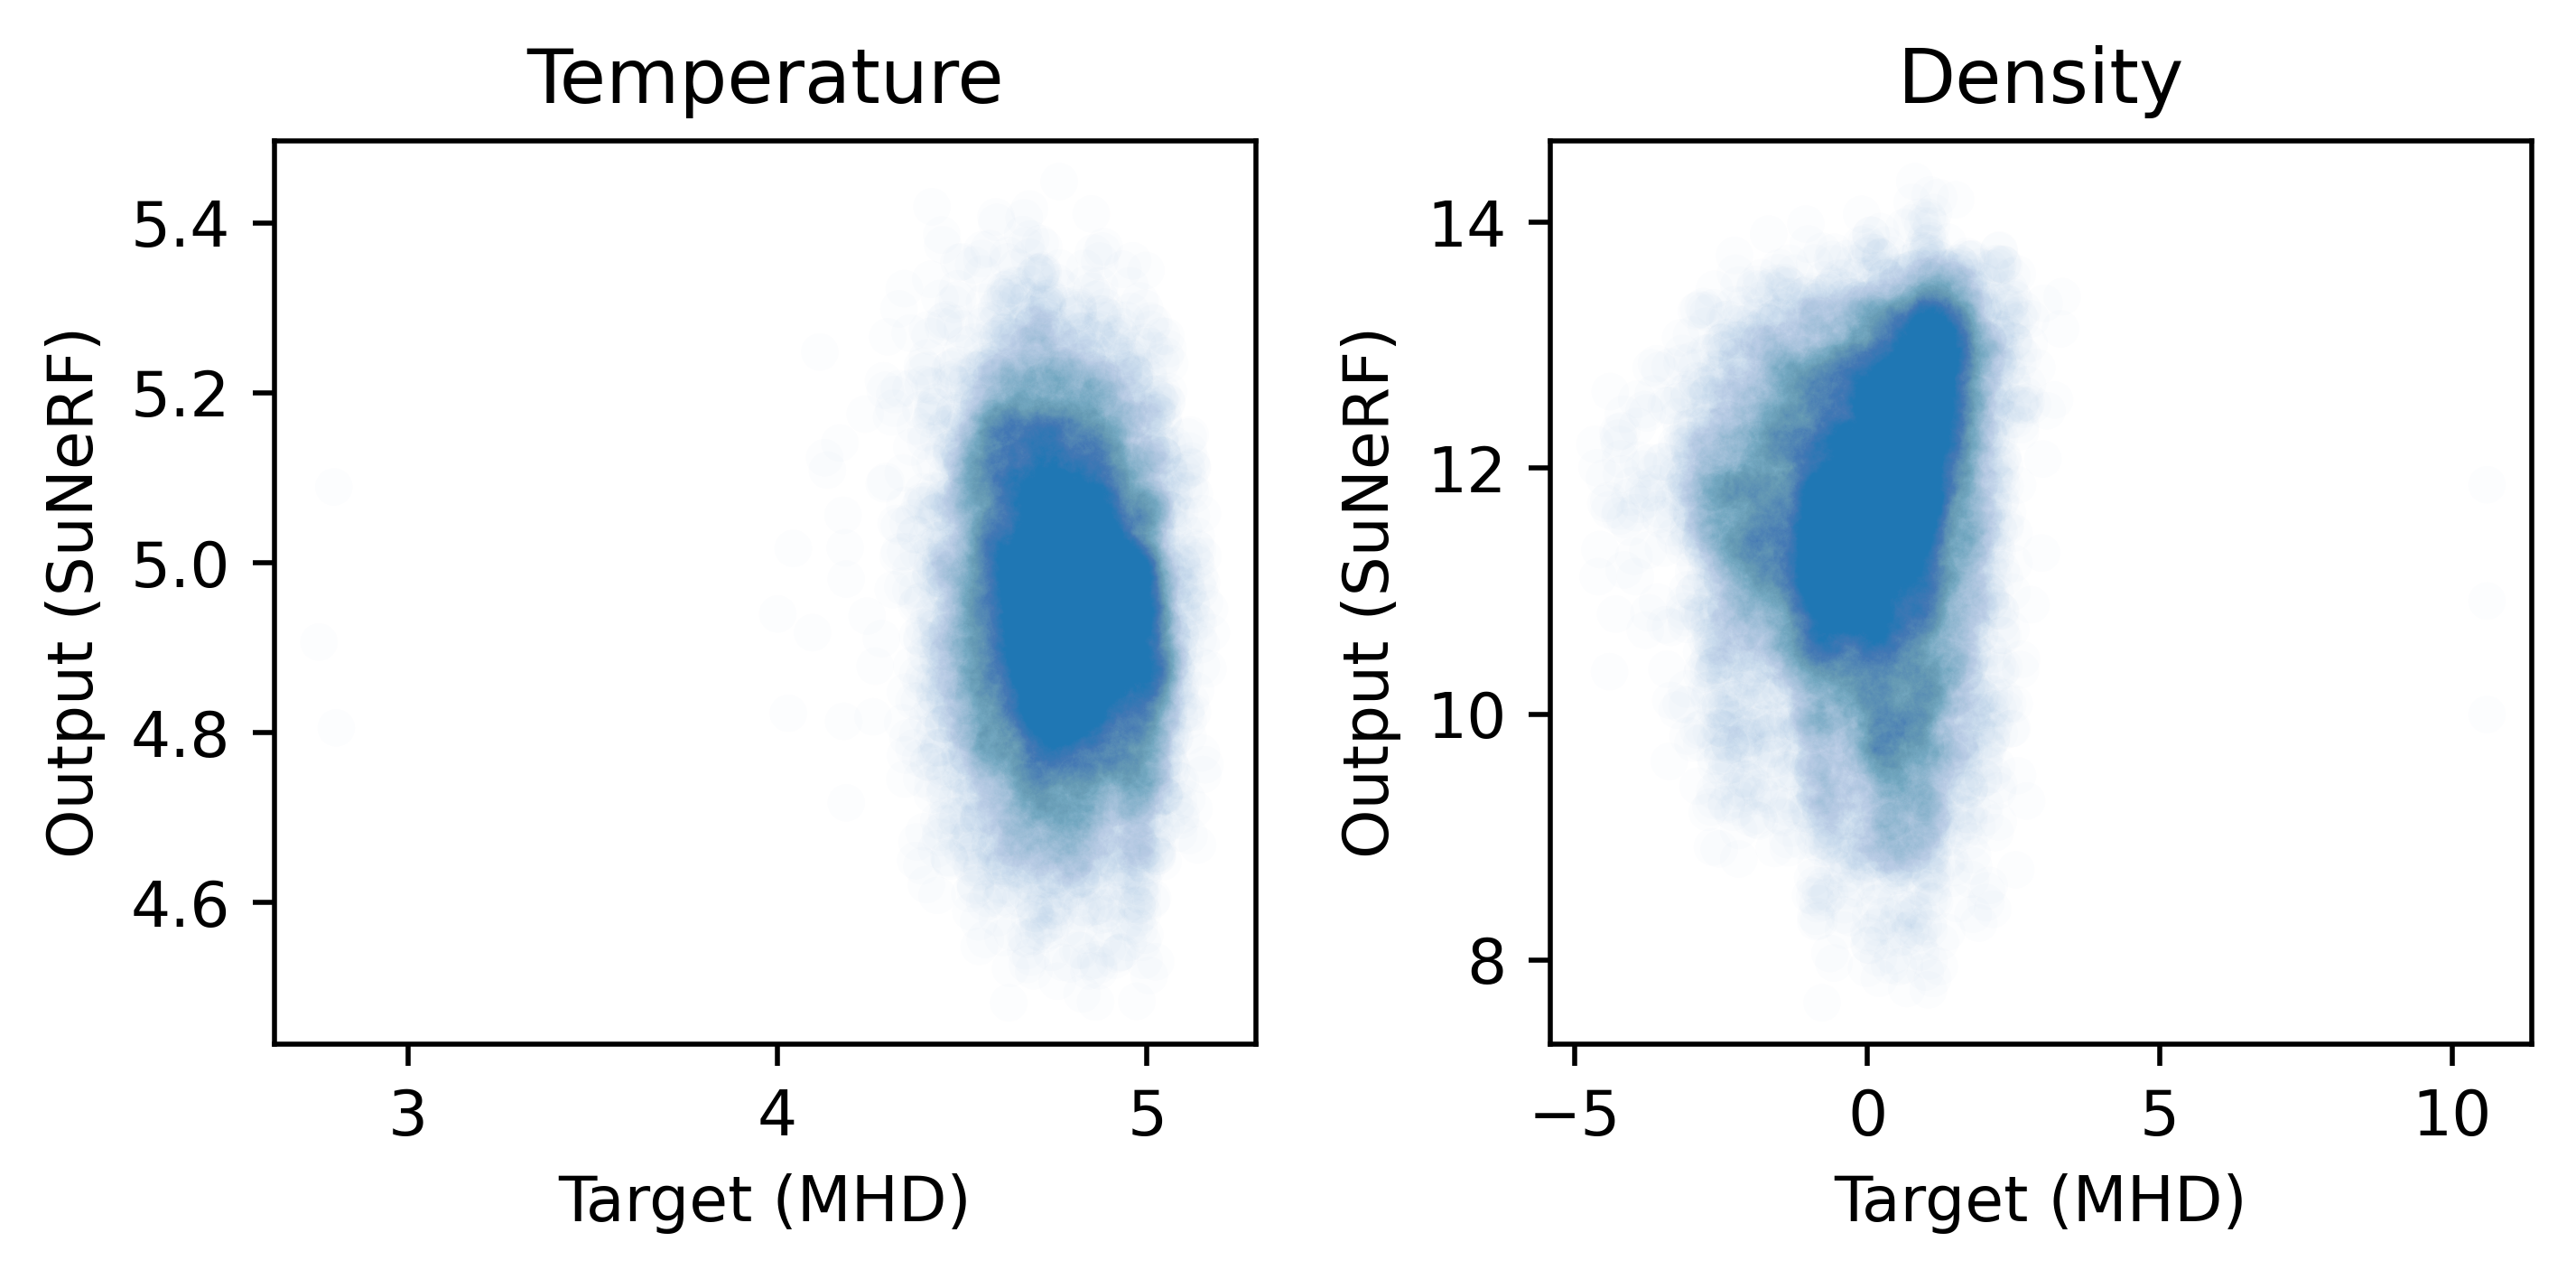

In [62]:
# SCATTER PLOT

# set up figure
fig = plt.figure(figsize=2*np.array([2.5, 1]), dpi=500)
gs0 = fig.add_gridspec(1, 2, wspace=0.3, hspace=0, left=0, right=1, bottom=0, top=1)

# plot temperatures for mhd and sunerf
ax = fig.add_subplot(gs0[0, 0])

# Temperature 
ax.scatter(t_mhd, t_nerf, alpha=0.01, ec='None')
# perfect_axis(ax, t_mhd, t_nerf)
# ax.plot([5.5,6.5],[5.5,6.5], '--k')
ax.set_xlabel('Target (MHD)')
ax.set_ylabel('Output (SuNeRF)')
ax.set_title('Temperature')

# plot densitiesfor mhd and sunerf
ax = fig.add_subplot(gs0[0, 1])
ax.scatter(rho_mhd, rho_nerf, alpha=0.01, ec='None')
# perfect_axis(ax, rho_mhd, rho_nerf)
# ax.plot([5,9],[5,9], '--k')

ax.set_xlabel('Target (MHD)')
ax.set_ylabel('Output (SuNeRF)')
ax.set_title('Density')

#print('MAE T', np.nanmean(np.abs(output_f[0][:,1].detach().cpu().numpy()+base_temp-te_at_locs)))
#print('MAE n', np.nanmean(np.abs(density_f.detach().cpu().numpy()-ne_at_locs)))

/var/tmp/ipykernel_1158025/2318978944.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('magma_r').copy()


Text(0.5, 1.0, 'Log$_{10}$ T')

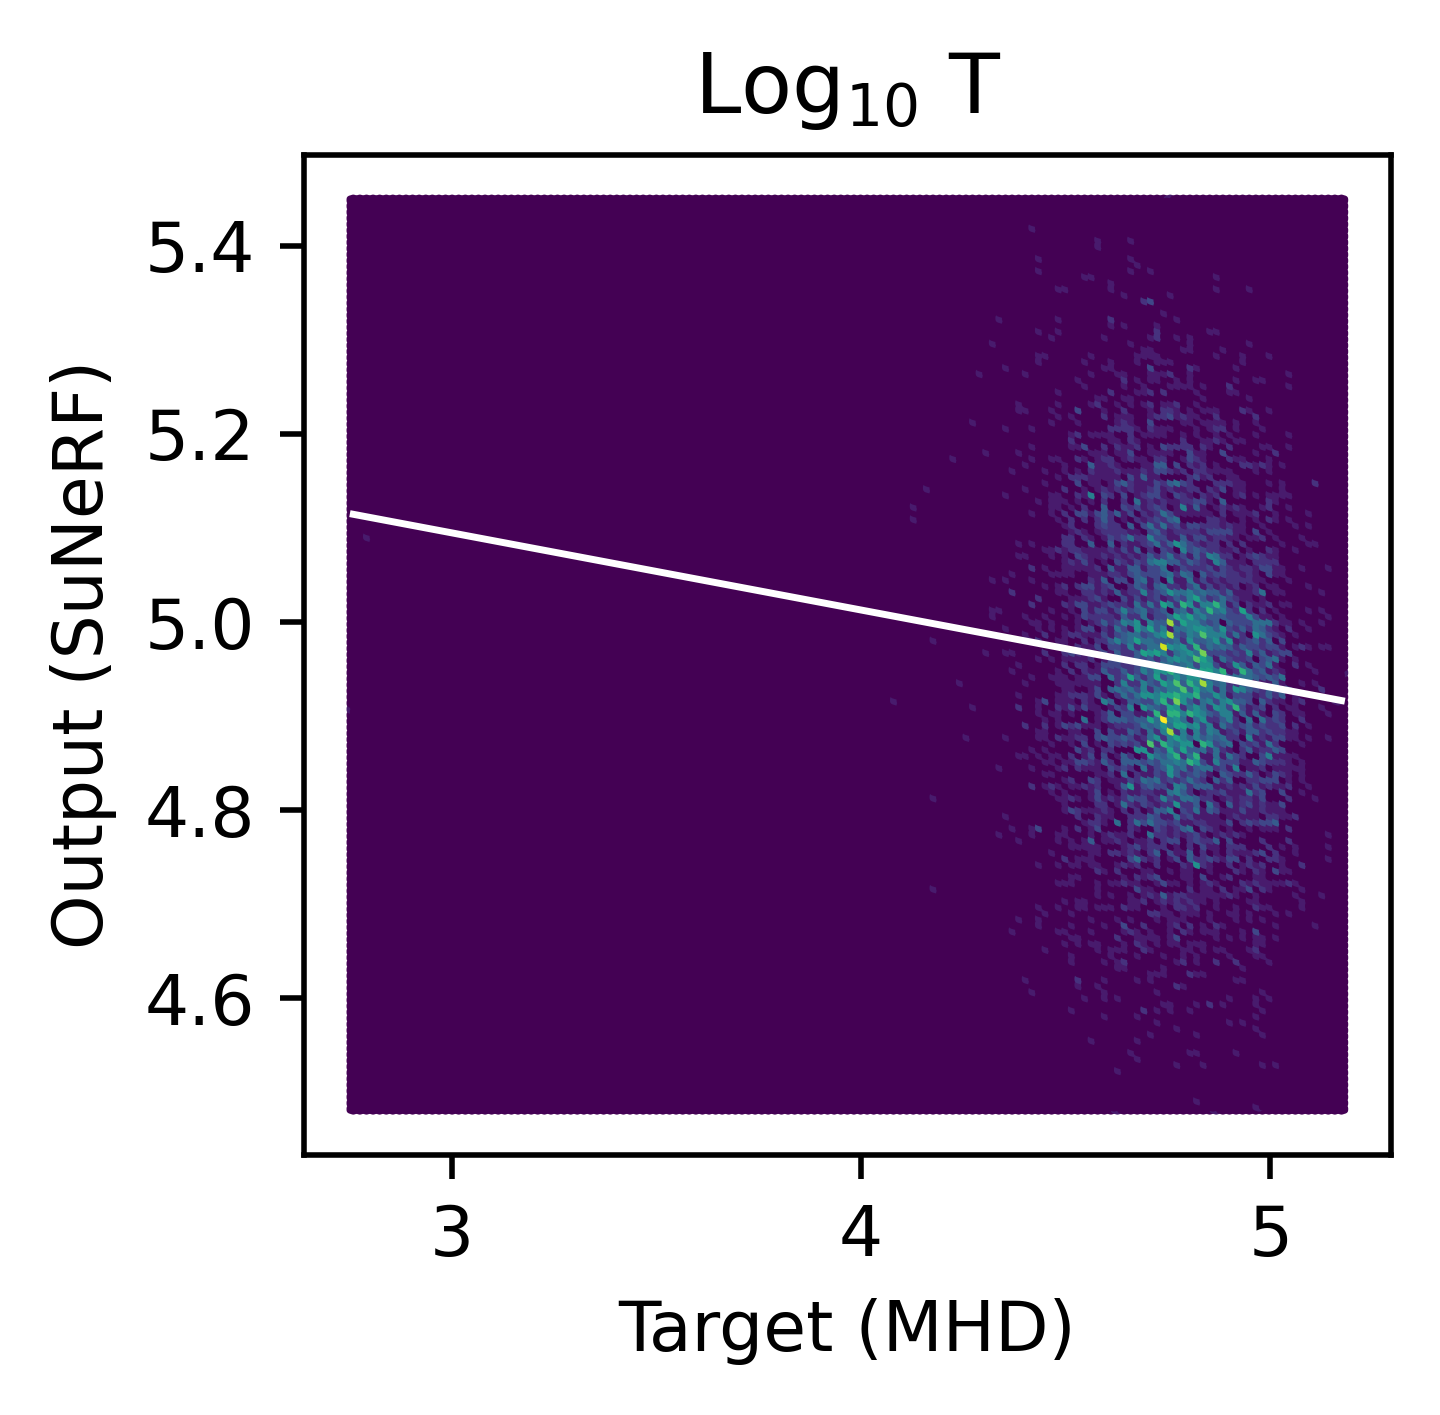

In [89]:
# 2D Histogram Plot

fig = plt.figure(figsize=2*np.array([2.5, 1]), dpi=500)
gs0 = fig.add_gridspec(1, 2, wspace=0.3, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])

x1 = 4.2
x2 = 5.4
nbins = 100

xbins = np.linspace(x1, x2, nbins)

cmap = mpl.cm.get_cmap('magma_r').copy()
cmap.set_under('w',1)

# histogram for target and output
# ax.hist2d(t_mhd, t_nerf, bins=xbins, cmap=cmap, cmin=1)
ax.hexbin(t_mhd, t_nerf, gridsize=(150, 150))

# polyfit line
ax.plot(np.unique(t_mhd),
        np.poly1d(np.polyfit(t_mhd, t_nerf, 1))(np.unique(t_mhd)),
        c="w",
        linewidth=1,
        )

# ax.plot([5.5,6.5],[5.5,6.5], '--k')
ax.set_facecolor('w')
ax.set_xlabel('Target (MHD)')
ax.set_ylabel('Output (SuNeRF)')
ax.set_title('Log$_{10}$ T')


# x1 = 
# x2 = 9
# nbins = 100

# xbins = np.linspace(x1, x2, nbins)

# ax = fig.add_subplot(gs0[0, 1])
# # ax.scatter(ne_at_locs,output_f[0][:,0].detach().cpu().numpy()+base_rho, alpha=0.01, ec='None')
# ax.hist2d(ne_at_locs, density_f.detach().cpu().numpy(), bins=xbins, cmap=cmap, cmin=1)
# ax.plot([5,9],[5,9], '--k')
# ax.set_facecolor('w')

# ax.set_xlabel('Target (MHD)')
# ax.set_ylabel('Output (SuNeRF)')
# ax.set_title('Log$_{10}$ n')

x1, x2 (-5, 5)


Text(0.5, 1.0, 'Log$_{10}$ Rho')

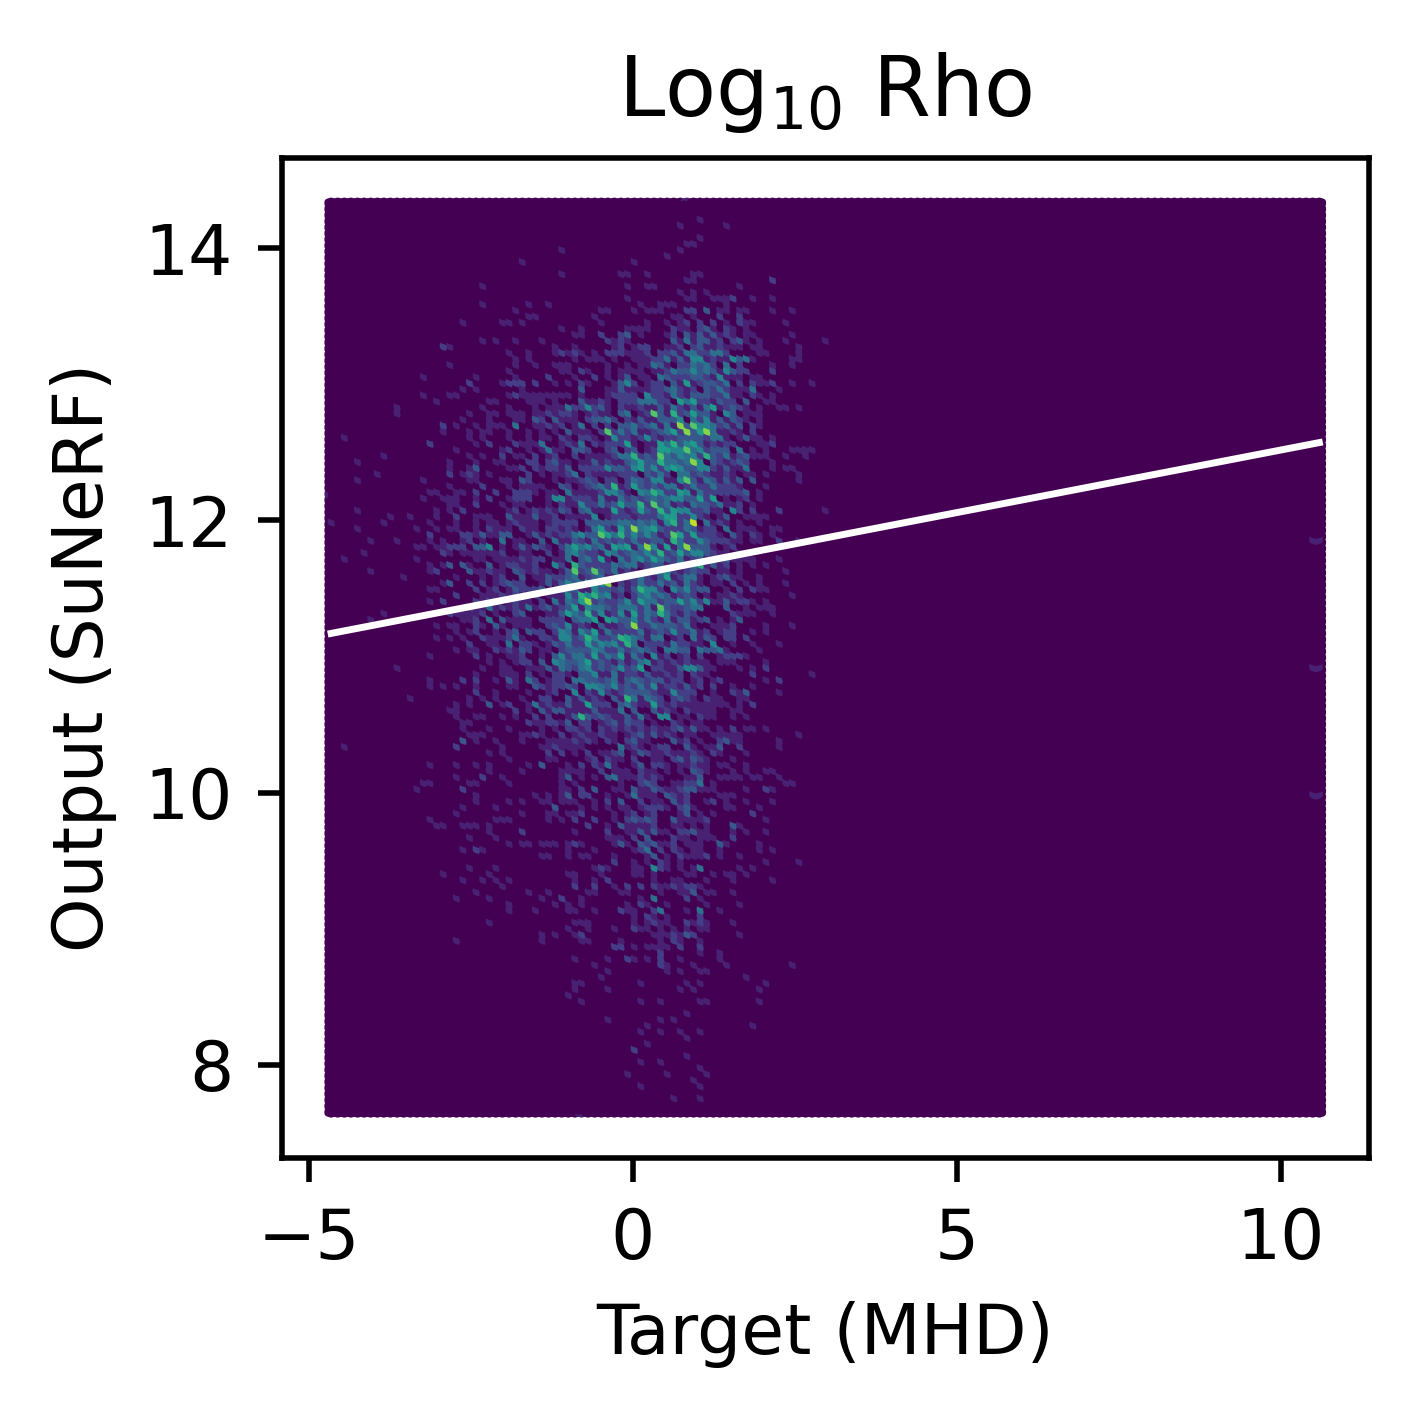

In [92]:
# Density 
fig = plt.figure(figsize=2*np.array([2.5, 1]), dpi=500)
gs0 = fig.add_gridspec(1, 2, wspace=0.3, hspace=0, left=0, right=1, bottom=0, top=1)


x1 = -5
x2 = 5
print(f"x1, x2 {x1, x2}")
nbins = 100

xbins = np.linspace(x1, x2, nbins)

ax = fig.add_subplot(gs0[0, 0])

# ax.scatter(ne_at_locs,output_f[0][:,0].detach().cpu().numpy()+base_rho, alpha=0.01, ec='None')
# histogram for target and output
# ax.hist2d(rho_mhd, rho_nerf, bins=xbins, cmap=cmap, cmin=1)
ax.hexbin(rho_mhd, rho_nerf, gridsize=(150, 150))

# polyfit line
ax.plot(np.unique(rho_mhd),
        np.poly1d(np.polyfit(rho_mhd, rho_nerf, 1))(np.unique(rho_mhd)),
        c="w",
        linewidth=1,
        )

# ax.plot([5.5,6.5],[5.5,6.5], '--k')
ax.set_facecolor('w')
ax.set_xlabel('Target (MHD)')
ax.set_ylabel('Output (SuNeRF)')
ax.set_title('Log$_{10}$ Rho')